# Continuous XOR Problem
XOR. Given two binary inputs
 and
, the label to predict is
 if either
 or
 is
 while the other is
, or the label is
 in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function. To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

 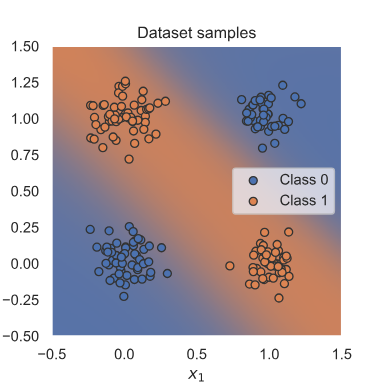

In [22]:
import torch.nn as nn
import torch.nn.functional as F

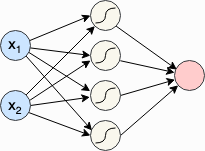

In [23]:
class XORClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [24]:
model = XORClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

XORClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [25]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package torch.utils.data.



In [26]:
import torch.utils.data as data


The data package defines two classes which are the standard interface for handling data in PyTorch: data.Dataset, and data.DataLoader. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.
# **The dataset class**

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: __getitem__, and __len__. The get-item function has to return the
i-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:



In [27]:
import torch
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [28]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([1.1902, 0.7234]), tensor(0))


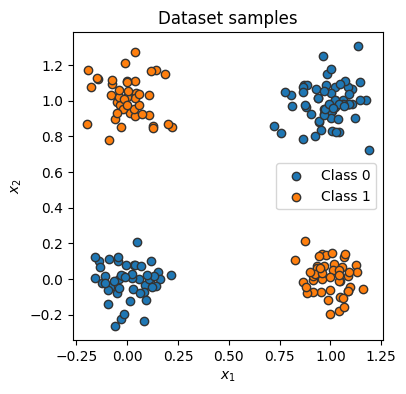

In [29]:
import matplotlib.pyplot as plt
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
visualize_samples(dataset.data, dataset.label)
plt.show()


# **Data Loader Class**
The class torch.utils.data.DataLoader represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function __getitem__, and stacks its outputs as tensors over the first dimension to form a batch. In contrast to the dataset class, we usually don’t have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list here):

batch_size: Number of samples to stack per batch

shuffle: If True, the data is returned in a random order. This is important during training for introducing stochasticity.

num_workers: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.

pin_memory: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.

drop_last: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.



In [30]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)


Data inputs torch.Size([8, 2]) 
 tensor([[ 1.0930,  0.9842],
        [-0.0324,  0.9759],
        [ 0.8846, -0.0808],
        [-0.1794,  1.0783],
        [ 0.9646,  1.2526],
        [ 0.9768,  1.0898],
        [ 0.9698,  0.9220],
        [ 0.7565,  0.8176]])
Data labels torch.Size([8]) 
 tensor([0, 1, 1, 1, 0, 0, 0, 0])


# **Optimization**
After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader

2. Obtain the predictions from the model for the batch

3. Calculate the loss based on the difference between predictions and labels

4. Backpropagation: calculate the gradients for every parameter with respect to the loss

5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

# **Loss modules**
We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:


where
 are our labels, and
 our predictions, both in the range of
. However, PyTorch already provides a list of predefined loss functions which we can use (see here for a full list). For instance, for BCE, PyTorch has two modules: nn.BCELoss(), nn.BCEWithLogitsLoss(). While nn.BCELoss expects the inputs
 to be in the range


, i.e. the output of a sigmoid, nn.BCEWithLogitsLoss combines a sigmoid layer and the BCE loss in a single class.

$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$

This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on “logits” where possible (remember to not apply a sigmoid on the output of the model in this case!).

For our model defined above, we therefore use the module nn.BCEWithLogitsLoss.

In [31]:
loss_module = nn.BCEWithLogitsLoss()


# **Stochastic Gradient Descent**
For updating the parameters, PyTorch provides the package torch.optim that has most popular optimizers implemented. We will discuss the specific optimizers and their differences later in the course, but will for now use the simplest of them: torch.optim.SGD.

Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss).

Therefore, we slowly move towards the direction of minimizing the loss.

A good default value of the learning rate for a small network as ours is 0.1.

In [32]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

The optimizer provides two useful functions: optimizer.step(), and optimizer.zero_grad().

The step function updates the parameters based on the gradients as explained above. The function optimizer.

zero_grad() sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation.

If we call the backward function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them.

Hence, remember to call optimizer.zero_grad() before calculating the gradients of a batch.

# **Training**
Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size.

In [33]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [35]:
# Push model to device. Has to be only done once
model.to(device)

XORClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In addition, we set our model to training mode. This is done by calling model.train(). There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using model.train() and model.eval().

In [36]:
## Progress bar
from tqdm.notebook import tqdm
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 3.5806,  3.3513],
        [ 1.6914,  1.9850],
        [ 1.1542,  1.6039],
        [ 1.3511, -0.9879]])), ('linear1.bias', tensor([-1.7487, -2.6940, -1.9582,  1.0424])), ('linear2.weight', tensor([[ 5.2197, -3.2947, -2.4741, -2.3997]])), ('linear2.bias', tensor([-2.7840]))])


In [38]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

In [39]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = XORClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[ 3.5806,  3.3513],
        [ 1.6914,  1.9850],
        [ 1.1542,  1.6039],
        [ 1.3511, -0.9879]])), ('linear1.bias', tensor([-1.7487, -2.6940, -1.9582,  1.0424])), ('linear2.weight', tensor([[ 5.2197, -3.2947, -2.4741, -2.3997]])), ('linear2.bias', tensor([-2.7840]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 3.5806,  3.3513],
        [ 1.6914,  1.9850],
        [ 1.1542,  1.6039],
        [ 1.3511, -0.9879]])), ('linear1.bias', tensor([-1.7487, -2.6940, -1.9582,  1.0424])), ('linear2.weight', tensor([[ 5.2197, -3.2947, -2.4741, -2.3997]])), ('linear2.bias', tensor([-2.7840]))])


# **Evaluation**
Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [40]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

As metric, we will use accuracy which is calculated as follows:


 $acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$


where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives.

When evaluating the model, we don’t need to keep track of the computation graph as we don’t intend to calculate the gradients. This reduces the required memory and speed up the model. In PyTorch, we can deactivate the computation graph using with torch.no_grad(): .... Remember to additionally set the model to eval mode.

In [41]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
eval_model(model, test_data_loader)


Accuracy of the model: 99.80%


Visualizing classification boundaries
To visualize what our model has learned, we can perform a prediction for every data point in a range of [-0.5, 1.5]
, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as 0
, and which as 1
. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

<Figure size 400x400 with 0 Axes>

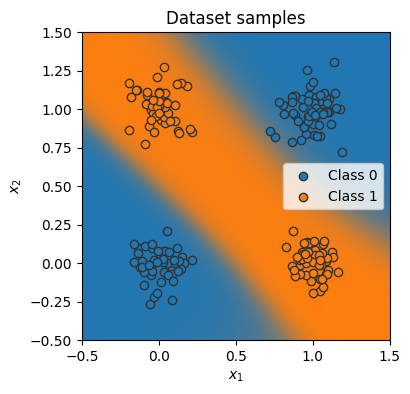

In [42]:
from matplotlib.colors import to_rgba
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    plt.figure(figsize=(4,4))
    fig = plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()